In [81]:
import sys
sys.path.append("../")
path = "../"

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfmm

from methods.implicit_perturb_2D import *

In [ ]:
pip install tqdm

In [ ]:
pip install gstools

In [ ]:
pip install scikit-fmm

In [ ]:
pip install statsmodels

### Load initial + truth from image w/ thresholding

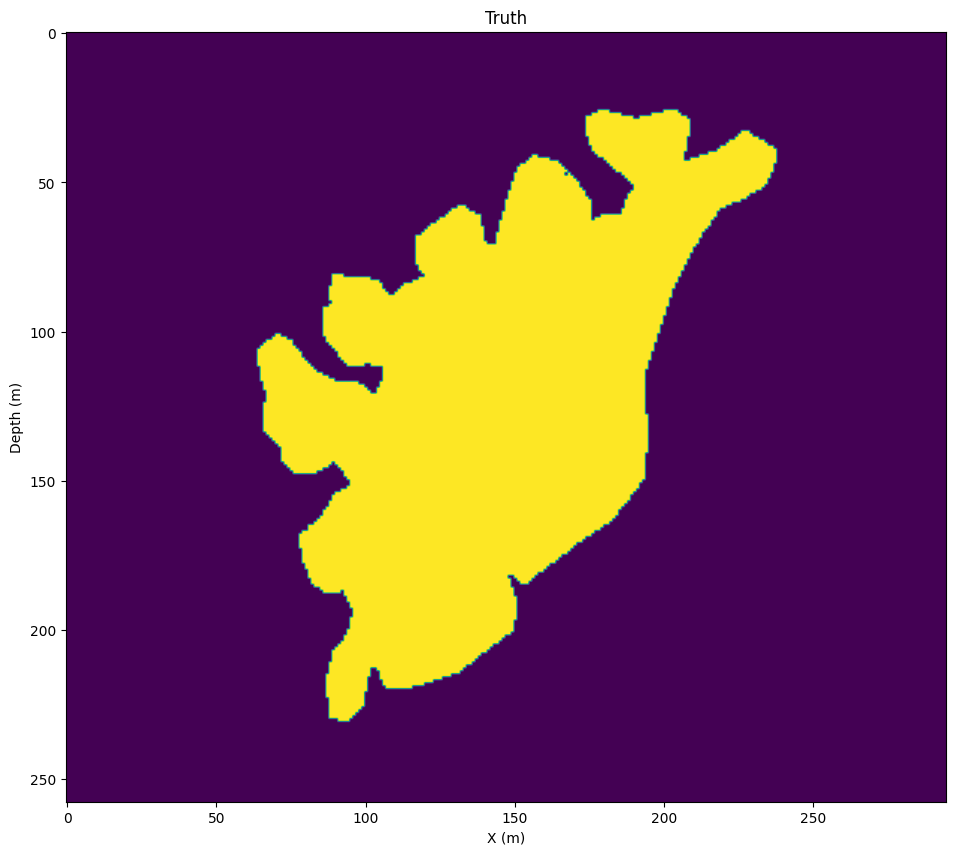

In [82]:
truth = cv2.imread('../data/data_gen_case/imgs/truth2.png', cv2.IMREAD_GRAYSCALE)
ret,thresh = cv2.threshold(truth, 20, 255, cv2.THRESH_BINARY)
thresh = (1 - ((thresh / 255) - 1) * -1)
truth = thresh

df = pd.DataFrame(truth)
df.to_csv('testing.csv')

plt.title('Truth')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.imshow(thresh)
plt.show()

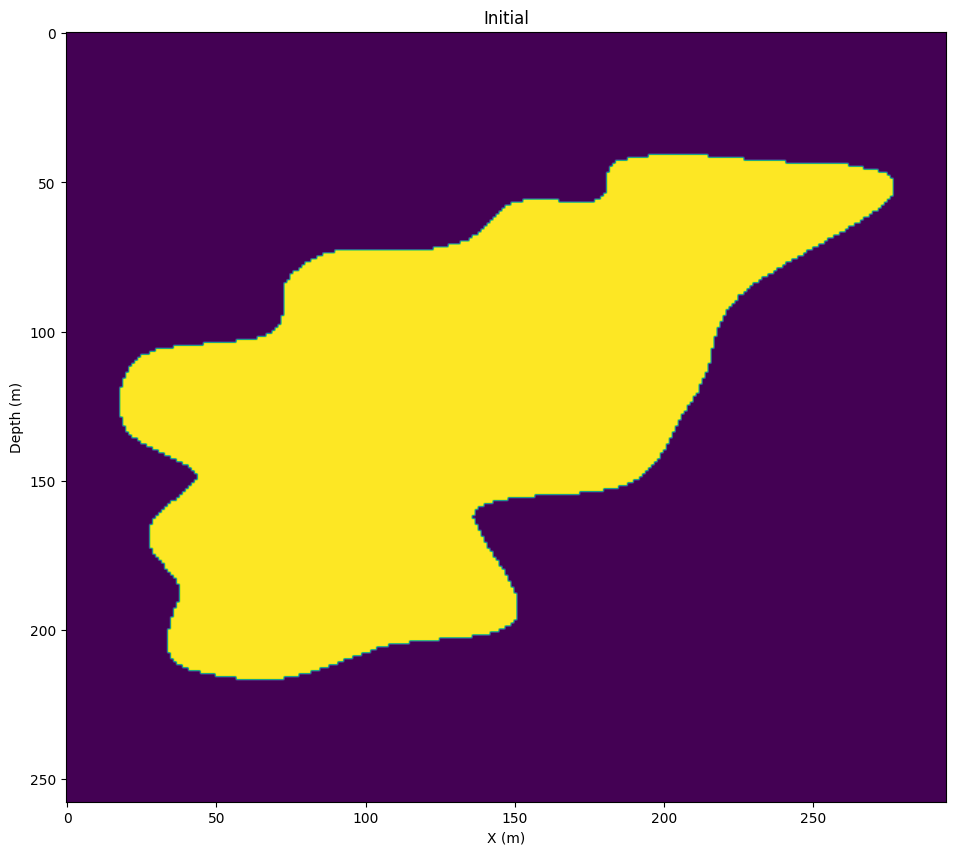

In [83]:
initial = cv2.imread('../data/data_gen_case/imgs/fake2.png', cv2.IMREAD_GRAYSCALE)
ret,thresh = cv2.threshold(initial, 20, 255, cv2.THRESH_BINARY)
thresh = (1 - ((thresh / 255) - 1) * -1)
truth = thresh

plt.title('Initial')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.imshow(thresh)
plt.show()

## testing hand gen shape with a single point

In [ ]:
truth = pd.read_csv('../data/peanut_case/maybe_good_data.csv')
truth = np.array(truth)
DF = pd.DataFrame(truth)

plt.imshow(truth)
plt.title('Truth')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

In [ ]:
initial = pd.read_csv('../data/peanut_case/initial_data_maybe_good.csv')
initial = np.array(initial)
DF = pd.DataFrame(initial)

plt.imshow(initial)
plt.title('Initial')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

### Load new contact points

In [84]:
new_contacts = pd.read_csv("../data/data_gen_case/paths/img2_contacts.csv")

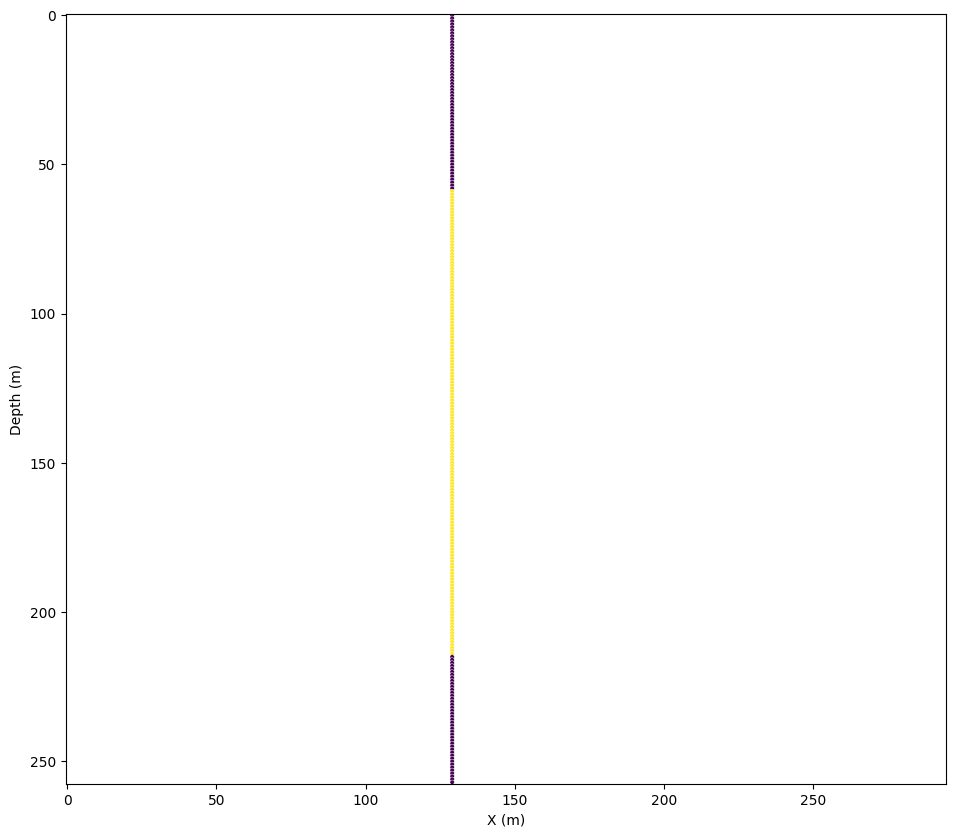

In [85]:
plt.imshow(truth, alpha = 0)
plt.scatter(new_contacts['x'], new_contacts['depth'],
            c=new_contacts['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()


### Initial Model

In [86]:
x_dim, y_dim= truth.shape
print(truth.shape)
x0 = 50; a = 10
y0 = 50; b = 20

x = np.linspace(0, x_dim,x_dim)[:,None]  # x values of interest
y = np.linspace(0, y_dim,y_dim)[:]  # y values of interest, as a "column" array

initial = initial*1

(258, 295)


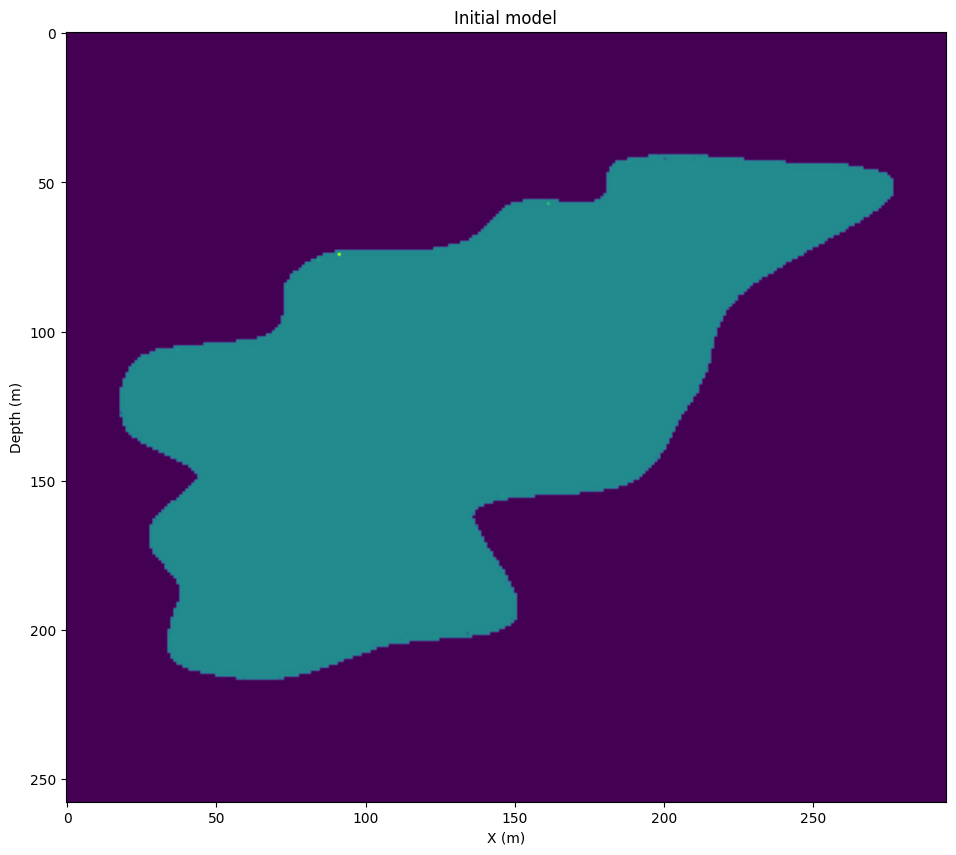

In [87]:
plt.imshow(initial)
plt.title('Initial model')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

### Trend estimation: MCMC on level sets M(x)

In [88]:
data = np.zeros(initial.shape)
data[:] = np.nan
data[np.array(new_contacts['depth'],dtype = 'int64'), np.array(new_contacts['x'], dtype = 'int64')] = truth[np.array(new_contacts['depth'], dtype = 'int64'), np.array(new_contacts['x'], dtype = 'int64')]
data[np.array(new_contacts[new_contacts['contacts']==1]['depth'],dtype = 'int64'),
     np.array(new_contacts[new_contacts['contacts']==1]['x'],dtype = 'int64')] = 0.5

In [89]:
initial = initial - 0.5
model = skfmm.distance(initial)

In [90]:
indicators_x_alpha = data[np.isfinite(data)]
indicators_x_alpha[indicators_x_alpha==0.5]=1

phi_x_alpha_ini = model[np.isfinite(data)]
phi_x_beta_ini = model[data==0.5]

loss_prev, o_ik_prev, o_bias_prev, o_var_prev =  loss_mean_function_v2(indicators_x_alpha,phi_x_alpha_ini,phi_x_beta_ini, model, data)
print(loss_prev)
sigma_coeff = 0.01
print('sigma = ', loss_prev*sigma_coeff)
print(o_ik_prev, o_bias_prev, o_var_prev)

254.23455775206207
sigma =  2.5423455775206207
24.910104432478747 114.62252129376223 114.7019320258211


#### run single chain

In [ ]:
iter_num = 3000
[model_cache, loss_cache, para_cache] = McMC_levelsets_2Dv2(model, data, 
                                                loss_function=loss_mean_function_v2,  
                                                sigma = 15, t_step = 1, iter_num = iter_num, 
                                                vel_range_x = [20, 40], vel_range_y = [20, 40],
                                                anisotropy_ang = [0, 180], num_mp = 0)
np.save('loss_cache.npy',loss_cache)
np.save('model_cache.npy',model_cache)
np.save('para_cache.npy',para_cache)

In [12]:
loss_cache = np.load(path+'notebook/loss_cache.npy')
model_cache = np.load(path+'notebook/model_cache.npy')
para_cache = np.load(path+'notebook/para_cache.npy')

#### run multichain

In [93]:
# You can run multiple chains using this code block
import multiprocessing
iter_num = 50

sigma = 15

input_list = [[model, data, loss_mean_function_v2, sigma,  1, iter_num, [50,100], [50,100],  [0,180], 13],
              [model, data, loss_mean_function_v2, sigma, 1, iter_num, [60,120], [60,120], [0,180], 14],
              [model, data, loss_mean_function_v2, sigma,  1, iter_num, [80,160], [80,160], [0,180], 15]]

# Trend estimation, McMC
# 6 runs
# the start indicate where we retrieve our velocity
if __name__ == '__main__':
    pool = multiprocessing.Pool(processes = 3)
    result = pool.map(mp_non_stationary_implicit_2D,input_list)
    pool.close()

  5%|▍         | 141/3000 [07:19<3:48:21,  4.79s/it]

Num_mp: 15Accept ratio: 0.6618705035971223, Loss function at iter 140: 91.86256125495773


  5%|▍         | 139/3000 [07:25<3:55:58,  4.95s/it]

KeyboardInterrupt: 

 24%|██▍       | 12/50 [00:57<03:04,  4.84s/it]

## Combining chains

#### If Gelmen_Rubin_Diagnostic < 1.1, then the chains have converged

#### single chain

In [64]:
def Gelmen_Rubin_Diagnostic(chain1, chain2, burn_in = 10000,length = 20000):
    
    n = chain1[burn_in:burn_in+length].shape[0]
    print(n)
    W = (chain1[burn_in:burn_in+length].std()**2 + chain2[burn_in:burn_in+length].std()**2)/2
    mean1 = chain1[burn_in:burn_in+length].mean()
    mean2 = chain2[burn_in:burn_in+length].mean()
    mean = (mean1 + mean2)/2
    B = n * ((mean1 - mean)**2 + (mean2 - mean)**2)
    var_theta = (1 - 1/n) * W + 1/n*B
    
    return np.sqrt(var_theta/W)

#### check multiple chains and search for deviations (> 1.1)

In [5]:
def multi_chain_gelman_rubin_diagnostic(chains, burn_in, length):
    segments = [chain[burn_in:burn_in+length] for chain in chains]
    n = segments[0].shape[0]
    W = np.mean([np.var(seg, ddof=1) for seg in segments])
    means = np.array([np.mean(seg) for seg in segments])
    overall_mean = np.mean(means)
    B = segments[0].shape[0] * np.var(means, ddof=1)
    var_theta  = (1 - 1/n) * W + 1/n*B
    R_hat = np.sqrt(var_theta / W)

    deviations = np.abs(means - overall_mean) > 2 * np.sqrt(W)
    if np.any(deviations):
        print("deviations: ", np.where(deviations)[0])

    return R_hat

In [25]:
model_cache_13 = np.load(path+'results/Case2_intrusion/13_trend_cache.npy')
model_cache_14 = np.load(path+'results/Case2_intrusion/14_trend_cache.npy')
model_cache_15 = np.load(path+'results/Case2_intrusion/15_trend_cache.npy')

chains = [model_cache_13, model_cache_14, model_cache_15]

R_hat = multi_chain_gelman_rubin_diagnostic(chains, burn_in = 300,length = 3000)
print("Gelman-Rubin Diagnostic (R-hat):", R_hat)

Gelman-Rubin Diagnostic (R-hat): 1.0185074624743786


In [83]:
print(model_cache_15.shape)

(3000, 181, 202)


#### combine chains and calculate summary

In [26]:
def combine_chains(chains, burn_in, length):
    # discard burn-in and combine
    segments = [chain[burn_in:burn_in+length] for chain in chains]
    combined_chains = np.concatenate([seg for seg in segments])
    return combined_chains

In [27]:
combined_model = combine_chains(chains, burn_in = 300,length = 3000)
model_cache = combined_model

print(model_cache.shape)

(8100, 181, 202)


In [ ]:
plt.rcParams["figure.figsize"] = (8, 4) 
plt.plot(loss_cache[:])
plt.title('Loss function')
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [ ]:
para_cache[para_cache==-1] = np.nan

In [ ]:
plt.rcParams["figure.figsize"] = (8, 4) 
iter_num = 50
plt.scatter(np.arange(iter_num),para_cache[:,2],s = 0.5)
plt.plot(para_cache[:,1],'.')
#plt.hist(para_cache[:,2])
#plt.hist(para_cache[:,3])
#plt.title('Loss function')
plt.xlabel('Iterations')
plt.ylabel('Loss')

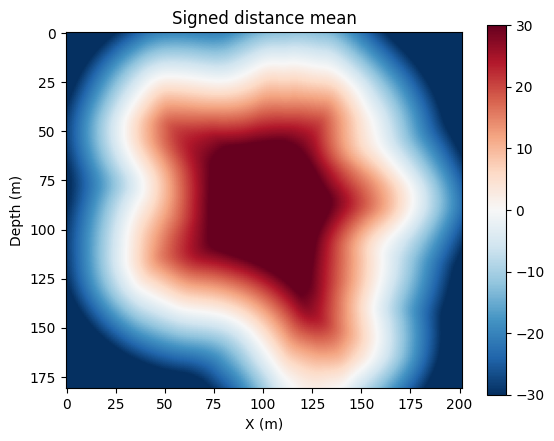

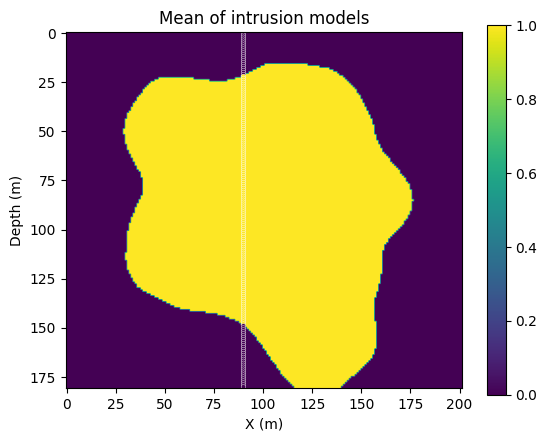

In [28]:
plt.imshow(np.mean(model_cache[1000:,:,:],axis = 0),vmin = -30,vmax =30,cmap = 'RdBu_r')
plt.colorbar()
plt.title('Signed distance mean')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

plt.imshow(np.mean(model_cache[1000:,:,:],axis = 0)>0)
plt.colorbar()
plt.scatter(new_contacts['x'], new_contacts['depth'],
            c=new_contacts['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.title('Mean of intrusion models')
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

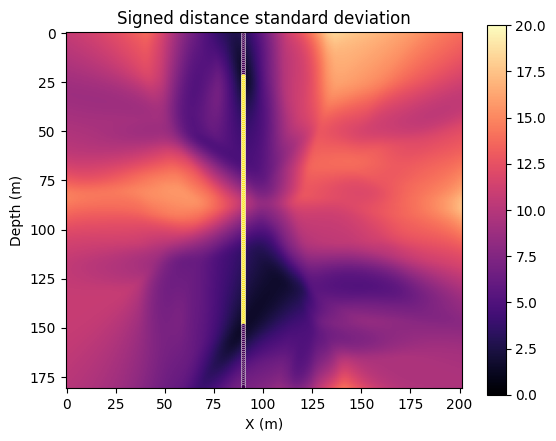

In [29]:
plt.imshow(np.std(model_cache[1000:,:,:],axis = 0),vmin = 0,vmax = 20, cmap = 'magma')
plt.colorbar()
plt.title('Signed distance standard deviation')
plt.scatter(new_contacts['x'], new_contacts['depth'],
            c=new_contacts['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

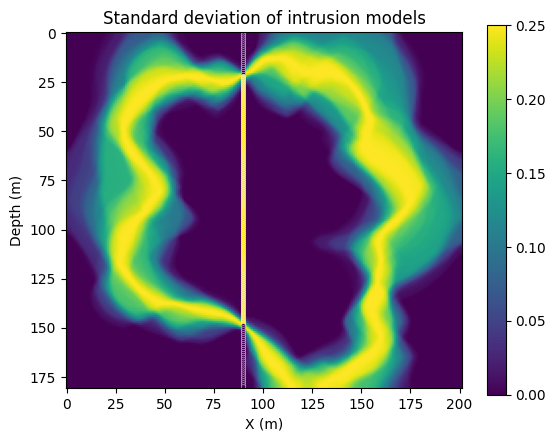

In [30]:
plt.imshow((np.var(model_cache[1000:,:,:]>0,axis = 0)))
plt.colorbar()
plt.title('Standard deviation of intrusion models')
plt.scatter(new_contacts['x'], new_contacts['depth'],
            c=new_contacts['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

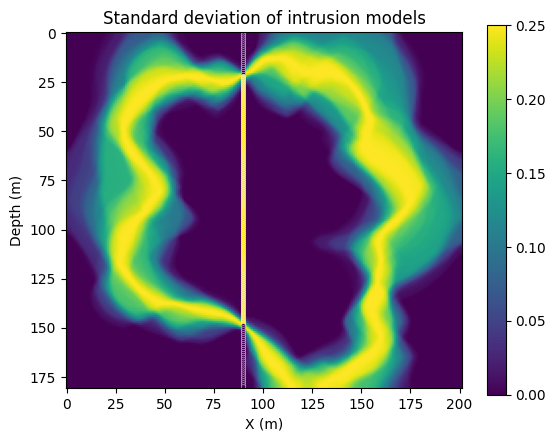

In [31]:
plt.imshow((np.var(model_cache[1000:,:,:]>0,axis = 0)))
plt.colorbar()
plt.title('Standard deviation of intrusion models')
plt.scatter(new_contacts['x'], new_contacts['depth'],
            c=new_contacts['litho'], edgecolors='w', linewidths=0.3,s = 10)

# plt.scatter(50,50,c = 'C2',s = 40)
# plt.text(50+4,50,'loc1',color = 'w')
# plt.scatter(200,100,c = 'C3',s = 40)
# plt.text(200+4,100,'loc2',color = 'b')

plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

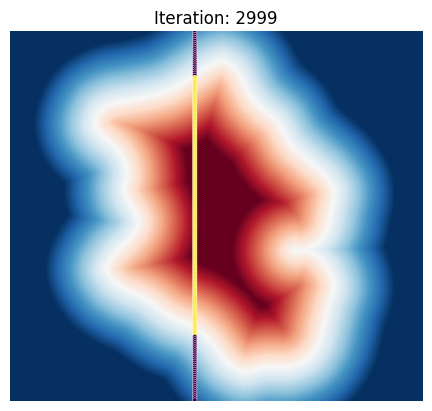

In [32]:
idx = 3000 - 1

plt.imshow(model_cache[idx,:,:],vmin = -30,vmax =30,cmap = 'RdBu_r')
#plt.colorbar()
plt.scatter(new_contacts['x'], new_contacts['depth'],
            c=new_contacts['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.title('Iteration: '+str(idx))
#plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.axis('off')
plt.show()

In [ ]:
def Gelmen_Rubin_Diagnostic(chain1, chain2, burn_in = 10000,length = 20000):
    
    n = chain1[burn_in:burn_in+length].shape[0]
    
    W = (chain1[burn_in:burn_in+length].std()**2 + chain2[burn_in:burn_in+length].std()**2)/2
    mean1 = chain1[burn_in:burn_in+length].mean()
    mean2 = chain2[burn_in:burn_in+length].mean()
    mean = (mean1 + mean2)/2
    B = n * ((mean1 - mean)**2 + (mean2 - mean)**2)
    var_theta = (1 - 1/n) * W + 1/n*B
    
    return np.sqrt(var_theta/W)

In [97]:
iter_num = 296152200 # 3000
model_cache_mean = np.mean(model_cache.reshape(iter_num,-1),axis = 1)
model_cache_std = np.std(model_cache.reshape(iter_num,-1),axis = 1)
plt.rcParams.update({'font.size': 15})
plt.rcParams["figure.figsize"] = (10, 4) 
plt.plot(model_cache_mean,label = 'field_mean')
plt.plot(model_cache_std,label = 'field_std')

plt.plot(model_cache[:,50,50],label = 'loc1')
plt.plot(model_cache[:,99,99],label = 'loc2')

plt.legend(bbox_to_anchor=(1., 1.03))
plt.xlabel('Lag')
plt.title('Trace plot')

Text(0.5, 1.0, 'Trace plot')

: 

In [36]:
cut_off = 200
from statsmodels.tsa.stattools import acf
acf_values = np.zeros((7900,model_cache.shape[1],model_cache.shape[2]))
for i in tqdm(range(model_cache.shape[1])):
    for j in range(model_cache.shape[2]):
        acf_values[:,i,j] = acf(model_cache[cut_off:,i,j],nlags = 10000)

100%|██████████| 181/181 [00:24<00:00,  7.35it/s]


Text(0.5, 1.0, 'Mean autocorrelation of all grids')

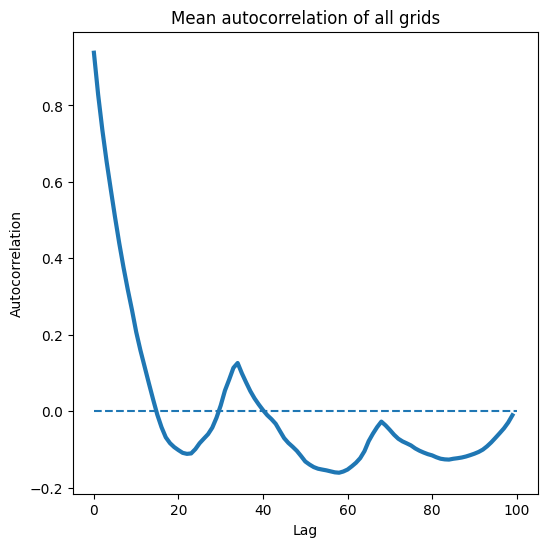

In [37]:
plt.rcParams["figure.figsize"] = (6, 6) 
plt.plot(np.mean(acf_values.reshape(100,-1),axis =1),linewidth = 3)
plt.hlines(xmin = 0, xmax = 100,y = 0,linestyle = '--')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Mean autocorrelation of all grids')

In [38]:
### acceptance rate curve
acc_rate = np.zeros(iter_num)
acc_rate[:] = np.nan

for iteration in np.arange(1,iter_num):
    acc_rate[iteration] = 1-np.sum((loss_cache[1:(iteration+1)]-loss_cache[0:iteration])==0)/iteration

NameError: name 'iter_num' is not defined

In [39]:
plt.rcParams["figure.figsize"] = (8, 4) 
plt.plot(np.arange(1,iter_num),acc_rate[1:])
plt.text(iter_num-2000, 0.5+0.1, np.round(acc_rate[-1],2))
plt.ylabel('acceptance rate')
plt.xlabel('Iterations')
plt.title('Acceptance rate')

NameError: name 'iter_num' is not defined

## residual simulation, velocity extension on each trend

### signed distance for each contact point

In [40]:
idx_at_contact = np.abs(np.gradient(data,axis = 0))>0

In [41]:
mc_pos_sdf = np.copy(model_cache[cut_off:,:,:])
sdf_at_contact = np.zeros((mc_pos_sdf.shape[0],np.sum(idx_at_contact)))
for i in tqdm(range(mc_pos_sdf.shape[0])):
    #mc_pos_sdf[i,:,:] = skfmm.distance(mc_pos[i,:,:]-0.5)
    sdf_at_contact[i,:] = mc_pos_sdf[i,:,:][idx_at_contact]

100%|██████████| 7900/7900 [00:00<00:00, 40881.01it/s]


Text(0.5, 1.0, 'Histogram of signed distance at the contact points')

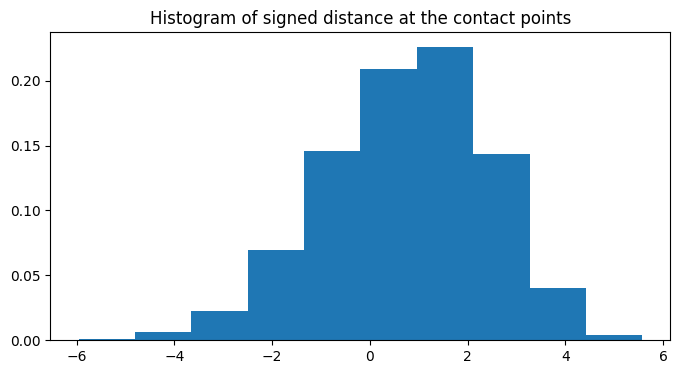

In [42]:
plt.hist(sdf_at_contact.reshape(-1),density = True)
plt.title('Histogram of signed distance at the contact points')

In [43]:
plus_pos = mc_pos_sdf[:,data==1]
minus_pos = mc_pos_sdf[:,data==0]

Text(0.5, 1.0, 'Borehole accuracy')

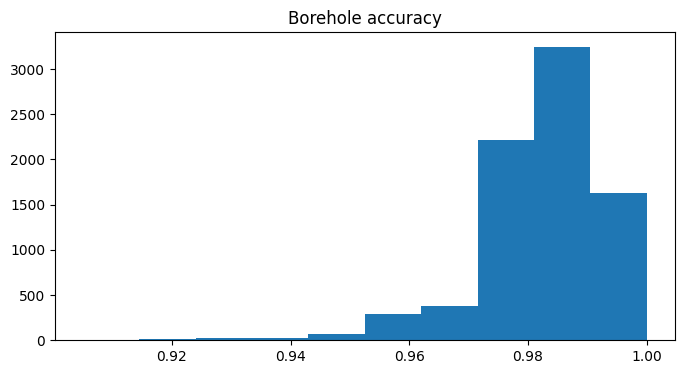

In [44]:
plt.rcParams["figure.figsize"] = (8, 4) 
plt.hist((np.sum(plus_pos>0,axis = 1)+np.sum(minus_pos<0,axis = 1))/(np.sum(data==0)+np.sum(data==1)))
plt.title('Borehole accuracy')

## Step 2: M(x) + R(x), Construct velocity with the above variance and do velocity extension

In [45]:
variance = np.var(sdf_at_contact.reshape(-1))

In [47]:
def extension_with_large_velocity(model):
    nx, ny = model.shape
    velocity = generate_m_2D([0,variance,20,20, np.random.uniform(0,180)], np.arange(nx), np.arange(ny), seed = None)
    # Here I choose the range 20 because trend can capture large scale variances larger than 20. 
    [_, F_eval] = skfmm.extension_velocities(model, velocity, dx=[1, 1],order = 1)
    
    max_iter_num = int(np.ceil(np.max(np.abs(F_eval))))
    for ii in range(max_iter_num):
        dt = 1/np.ceil(np.max(np.abs(F_eval)))
        delta_phi = dt * F_eval
        model_next = model - delta_phi # Advection
        model = skfmm.distance(model_next)
    return model

In [66]:
iter_num = 8100
print(model_cache.shape)
mc_pos_sdf_selected = model_cache[np.arange(cut_off,iter_num,100),:,:]

(8100, 181, 202)


In [67]:
mc_pos_sdf_plus_residual = np.zeros(mc_pos_sdf_selected.shape)
for i in tqdm(range(mc_pos_sdf_selected.shape[0])):
    mc_pos_sdf_plus_residual[i,:,:] = extension_with_large_velocity(mc_pos_sdf_selected[i,:,:])

100%|██████████| 79/79 [01:00<00:00,  1.31it/s]


## Step 3:  M(x) + R(x) with perfect match, Ensemble smoother for final matches

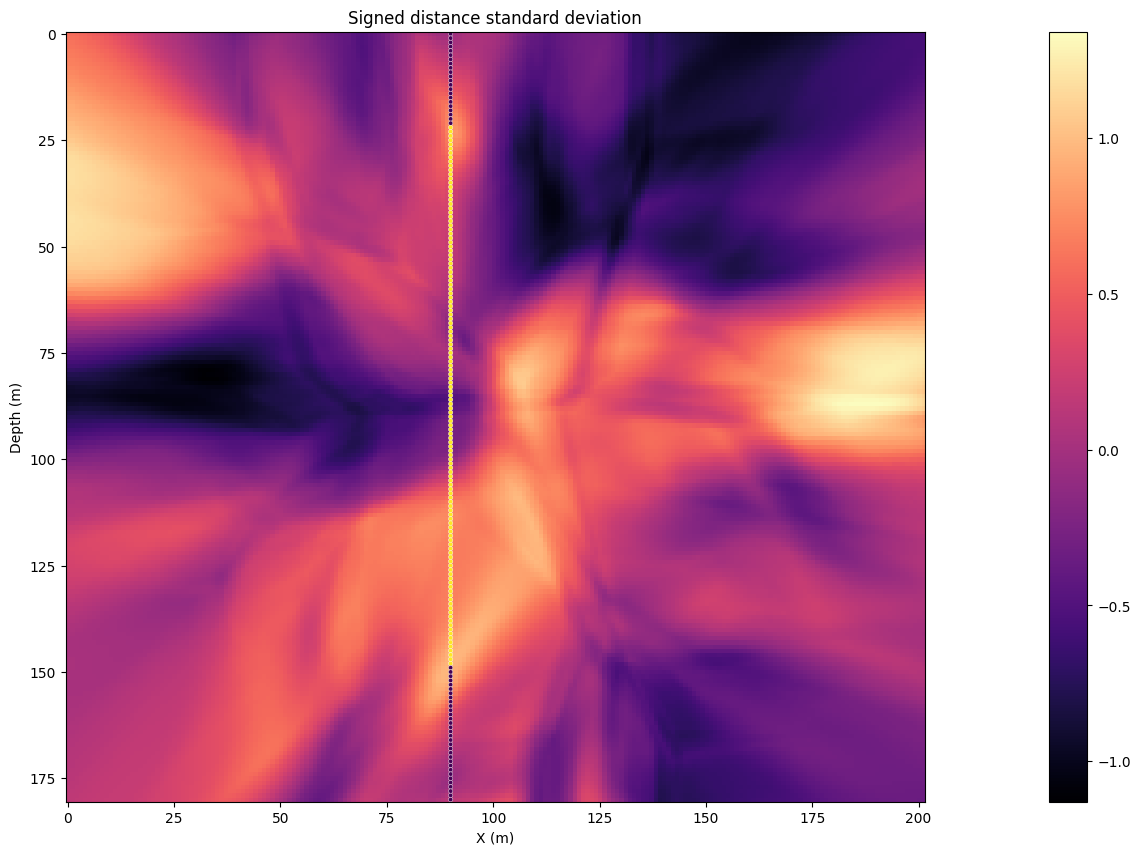

In [68]:
plt.imshow(np.std(mc_pos_sdf_plus_residual[:,:,:],axis = 0)-np.std(model_cache[1000:,:,:],axis = 0), cmap = 'magma')
plt.colorbar()
plt.title('Signed distance standard deviation')
plt.scatter(new_contacts['x'], new_contacts['depth'],
            c=new_contacts['litho'], edgecolors='w', linewidths=0.3,s = 10)
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.show()

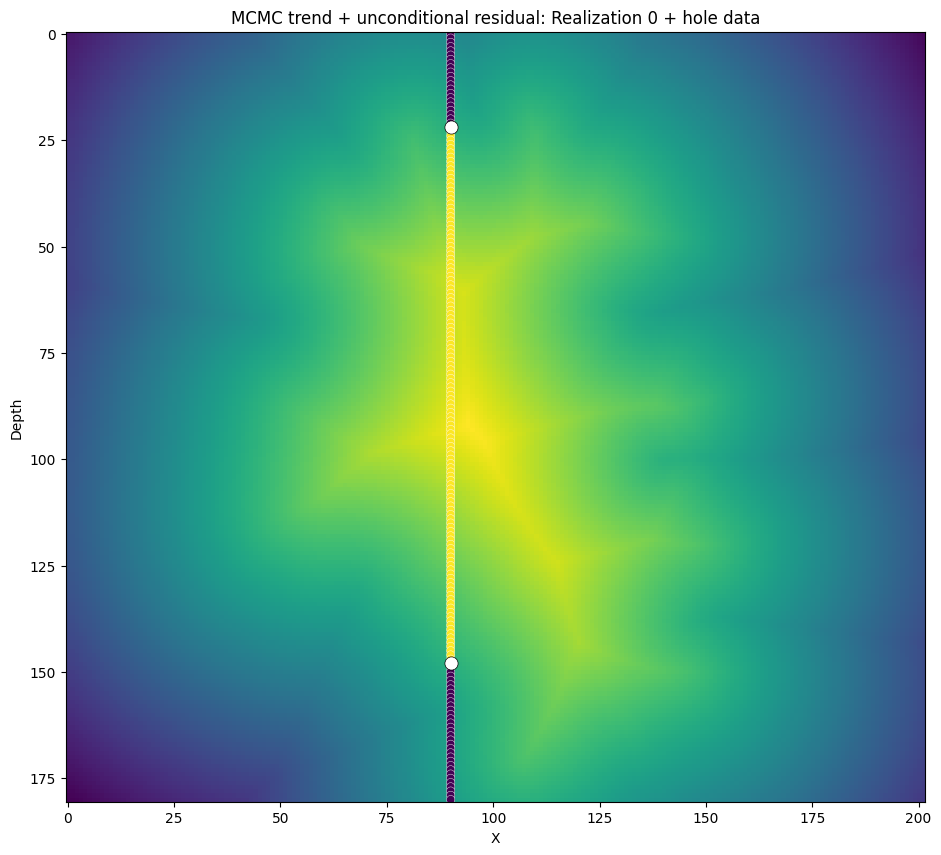

In [69]:
idx = 0
plt.imshow(mc_pos_sdf_plus_residual[idx,:,:])
plt.scatter(new_contacts['x'], new_contacts['depth'],
            c=new_contacts['litho'], edgecolors='w', linewidths=0.3)
plt.scatter(new_contacts['x'][new_contacts['contacts']==1], new_contacts['depth'][new_contacts['contacts']==1],
            c='w', edgecolors='k', linewidths=0.5,s=90)

plt.title('MCMC trend + unconditional residual: Realization '+str(idx)+' + hole data')
plt.ylabel('Depth'), plt.xlabel('X')
plt.show()

In [70]:
# Sigmoid on DT
def sigmoid(prior_DT):
    return 1/(1 + np.exp(-prior_DT*10))

def ensemble_smoother(m,d,d_obs):
    # no measurement error for now
    # covaraince matrix of d: cov_d
    cov_d = np.cov(d)
    # cross-covariance matrix: cov_m_d, m can be very large so I split into small piece and calculate the covariance matrix.
    start = 0
    sep = 1000
    cov_m_d = np.zeros((m.shape[0],d.shape[0]))
    for end in np.arange(0,m.shape[0],sep)+sep:
        cov_m_d[start:end,:] = np.cov(m[start:end,:],d)[:m[start:end,:].shape[0],m[start:end,:].shape[0]:]
        start = end

    K = np.dot(cov_m_d, np.linalg.inv(cov_d))
    m_pos = m + np.dot(K,d_obs-d)

    return m_pos

In [80]:
mc_pos_sdf_plus_residual_S_DT = sigmoid(mc_pos_sdf_plus_residual)

/var/folders/1c/056txszn77q0jr76_h81g4lm0000gn/T/ipykernel_51810/1161685376.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-prior_DT*10))


In [72]:
data[data == 0.5] = np.nan
d = mc_pos_sdf_plus_residual_S_DT[:,~np.isnan(data)]
d_obs = data[~np.isnan(data)]

d_obs = d_obs[np.var(d,axis = 0)>1e-6] # only invert boreholes with variance > 0.05. Mathemtically > 0 should be fine. 
d = d[:,np.var(d,axis = 0)>1e-6]

In [73]:
mc_pos_sdf_plus_residual_S_DT_pos = ensemble_smoother(mc_pos_sdf_plus_residual_S_DT.reshape(mc_pos_sdf_selected.shape[0],-1).T,
                                                      d.T,d_obs.reshape(-1,1)).T

In [75]:
borehole = new_contacts
def vis_ensembles_mean_var(plot_model):
    
    plt.rcParams['figure.figsize'] = 32, 10
    fig, axs = plt.subplots(1, 5)
    i = 0
    for ax in axs.flat[:3]:
        ax.imshow(plot_model[i*1+1,:,:]>0.5,vmin = 0, vmax = 1)
        ax.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3)
        ax.scatter(borehole['x'][borehole['contacts']==1], borehole['depth'][borehole['contacts']==1],
                    c='w', edgecolors='k', linewidths=0.5,s=90)
        ax.axis('off')
        ax.set_title('Realization '+str(i*100+1),fontsize = 25)
        i = i + 1

    ax = axs.flat[3]
    ax.imshow(np.mean(plot_model,axis = 0),vmin = 0, vmax = 1)
    ax.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3)
    ax.scatter(borehole['x'][borehole['contacts']==1], borehole['depth'][borehole['contacts']==1],
            c='w', edgecolors='k', linewidths=0.5,s=90)
    ax.axis('off')
    ax.set_title('Mean',fontsize = 25)

    ax = axs.flat[4]
    ax.imshow(np.var(plot_model,axis = 0),vmin = 0, vmax = 0.1)
    ax.scatter(borehole['x'], borehole['depth'],
            c=borehole['litho'], edgecolors='w', linewidths=0.3)
    ax.scatter(borehole['x'][borehole['contacts']==1], borehole['depth'][borehole['contacts']==1],
            c='w', edgecolors='k', linewidths=0.5,s=90)    
    ax.axis('off')
    ax.set_title('Variance',fontsize = 25)

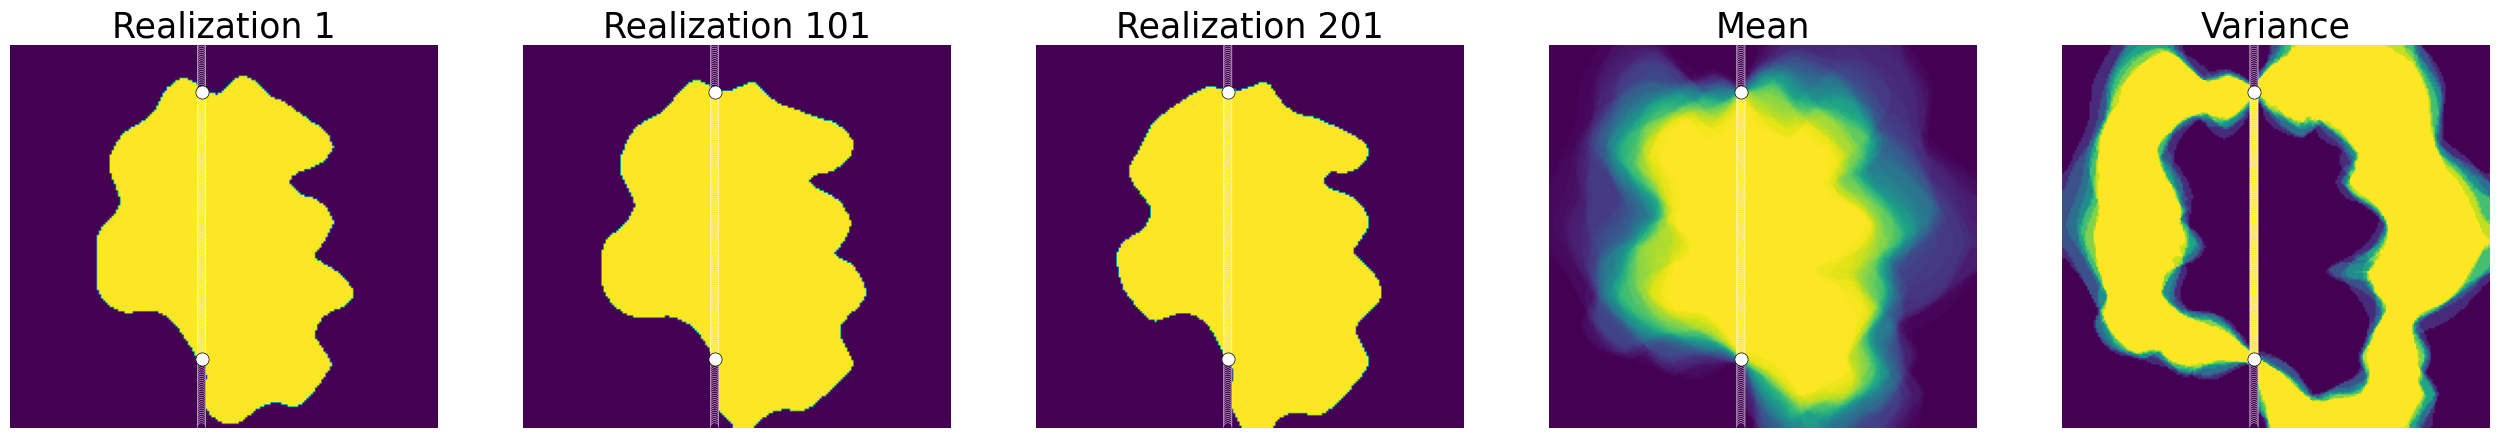

In [76]:
vis_ensembles_mean_var((mc_pos_sdf_selected>0)*1)

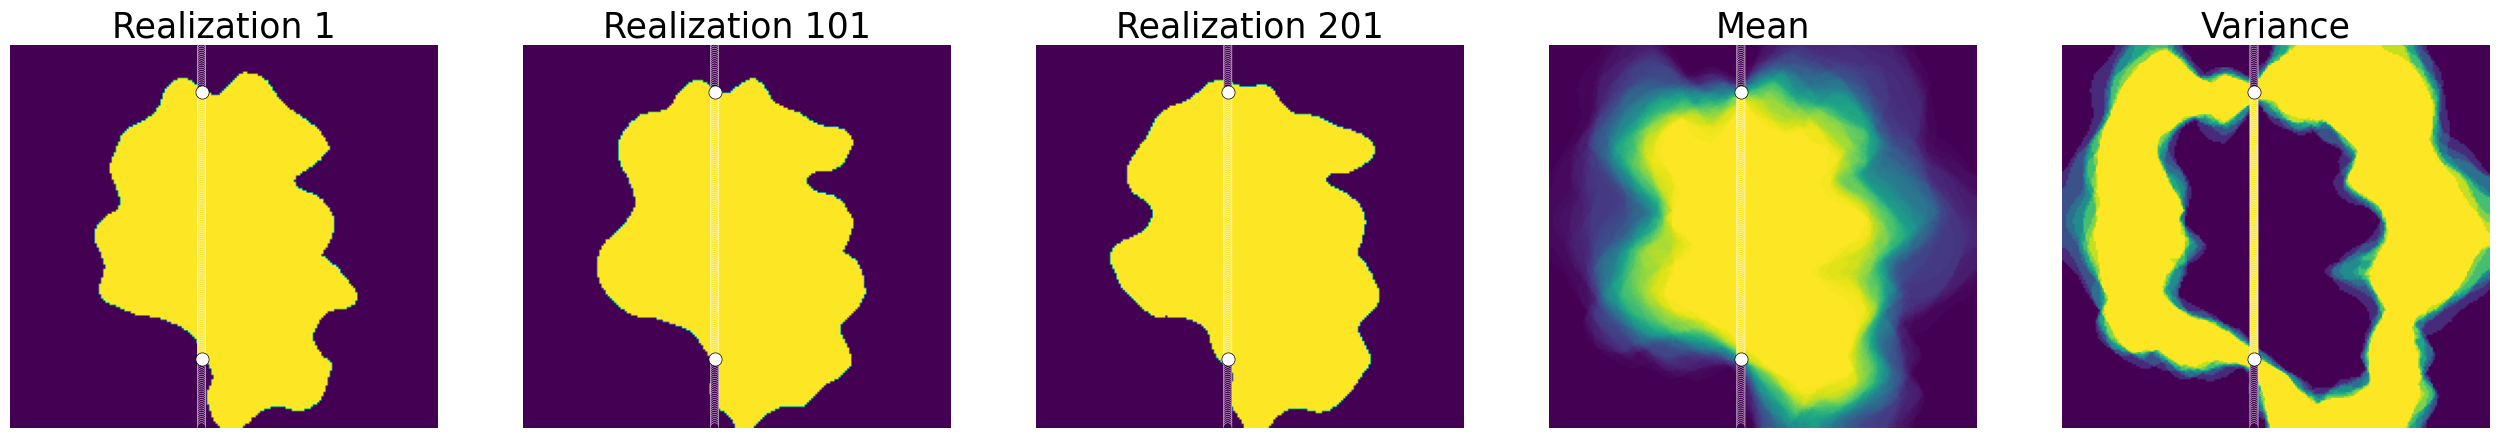

In [77]:
vis_ensembles_mean_var((mc_pos_sdf_plus_residual_S_DT>0.5)*1)

In [78]:
mc_pos_sdf_plus_residual_S_DT_pos = mc_pos_sdf_plus_residual_S_DT_pos.reshape(mc_pos_sdf_selected.shape)

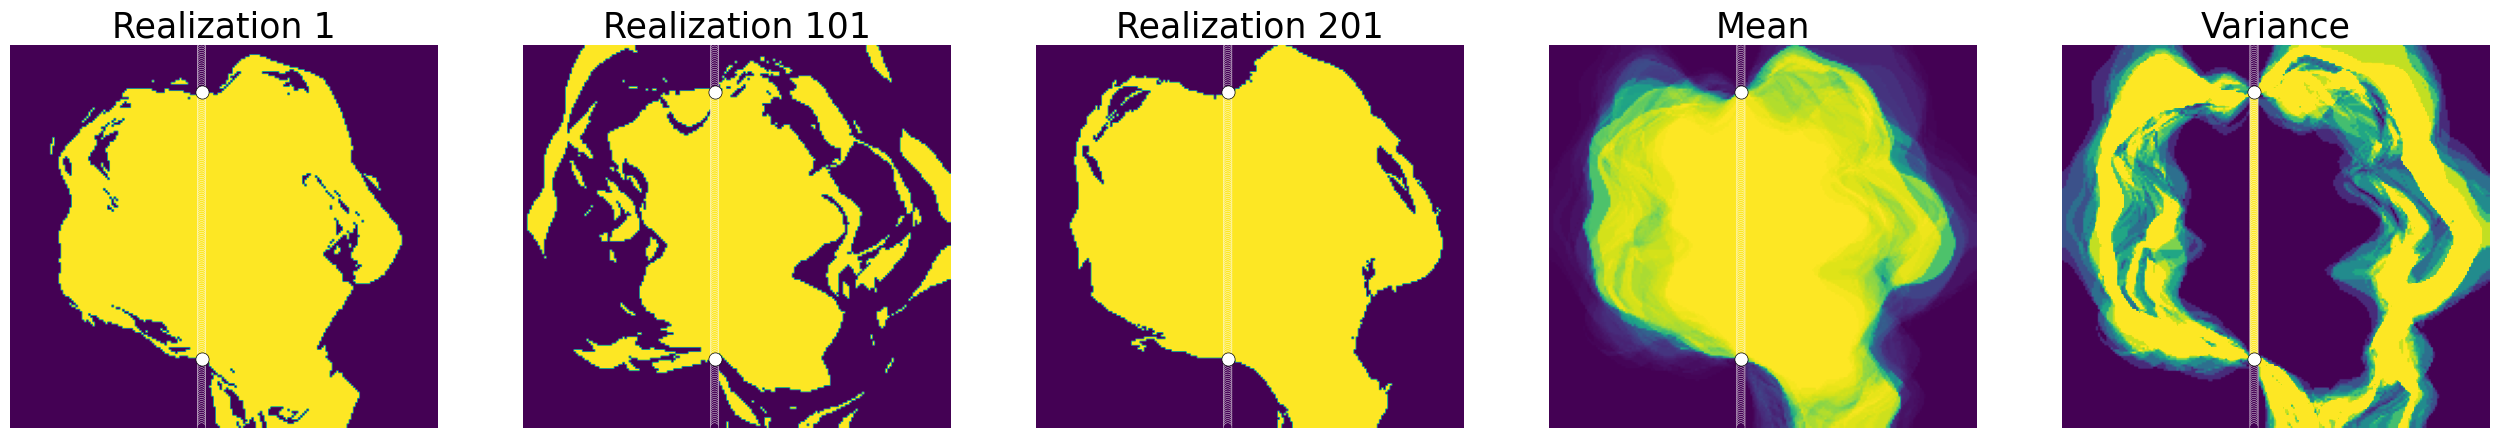

In [79]:
vis_ensembles_mean_var((mc_pos_sdf_plus_residual_S_DT_pos>0.5)*1)

In [73]:
plus_pos = mc_pos_sdf_plus_residual_S_DT_pos[:,data==1]
minus_pos = mc_pos_sdf_plus_residual_S_DT_pos[:,data==0]

(array([ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0., 24.]),
 array([0.93854749, 0.94469274, 0.95083799, 0.95698324, 0.96312849,
        0.96927374, 0.97541899, 0.98156425, 0.9877095 , 0.99385475,
        1.        ]),
 <BarContainer object of 10 artists>)

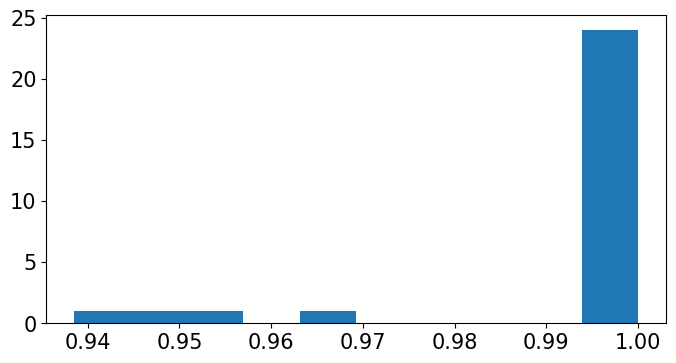

In [74]:
plt.rcParams["figure.figsize"] = (8, 4) 
plt.hist((np.sum(plus_pos>0.5,axis = 1)+np.sum(minus_pos<=0.5,axis = 1))/(np.sum(data==0)+np.sum(data==1)))